# ABC inference over simulations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(df, int_vars:list, ax_arg=None, total=False,log=False, Reff=None,plotpath=False,legend=False,summary=False):
    if ax_arg is None:
        if Reff is None:
            fig, ax = plt.subplots(figsize=(12,9))
        else:
            #fig, (ax,ax2) = plt.subplots(figsize=(12,9),nrows=2,gridspec_kw={'height_ratios': [3, 1.5]}, sharex=True)
            fig = plt.figure(constrained_layout=True)
            gs = fig.add_gridspec(3, 1)
            ax = fig.add_subplot(gs[:2, 0])
            
            ax2 = fig.add_subplot(gs[2, 0],sharex=ax)
    else:

        ax2 = ax_arg[1]
        ax = ax_arg[0]
    if summary:
        #Using summary files
  
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.loc[(var,'lower')], df.loc[(var,'upper')], alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.loc[(var,'bottom')], df.loc[(var,'top')], alpha=0.4,color='C0')

            if plotpath:
                print("Cannot plot path using summary files")
                raise KeyError
            else:
                ax.plot(df.columns, df.loc[(var,'median')], label=var)

            ax.set_xticks([df.columns.values[-42]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #using the raw simulation files
        if total:
            for n in range(df.loc['symp_obs'].shape[0]):
                df.loc[('total_inci_obs',n),:] = df.loc[(int_vars[0],n)] + df.loc[(int_vars[1],n)]
            int_vars=['total_inci_obs']
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.05,axis=1), df.transpose()[var].quantile(0.95,axis=1), alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.25,axis=1), df.transpose()[var].quantile(0.75,axis=1), alpha=0.4,color='C0')

            if plotpath:
                ax.plot(df.columns, df.loc[(var,4)], label=var,alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,8)],alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,12)],alpha=0.8,color='C0')
            else:
                ax.plot(df.columns, df.transpose()[var].quantile(0.5,axis=1), label=var)

            ax.set_xticks([df.columns.values[-70]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')
    
    if len(int_vars)>1:
        ax.legend()
    ax.set_ylim(bottom=0)
    #ax.set_ylabel("Cases")
    if log:
        ax.set_yscale("log")
    if legend:
        fig.legend()
    
    if Reff is not None:
        
        ax2.plot(df.columns, Reff.loc[df.columns,'median'])
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'bottom'],Reff.loc[df.columns, 'top'],alpha=0.4 ,color='C0')
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'lower'],Reff.loc[df.columns, 'upper'],alpha=0.4,color='C0' )
        ax2.set_yticks([1],minor=True,)
        ax2.set_yticks([0,2],minor=False)
        ax2.set_yticklabels([0,2],minor=False)
        ax2.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
        #ax2.set_ylabel("Reff")
        ax2.tick_params('x',rotation=45)
        plt.setp(ax.get_xticklabels(), visible=False)
        #ax2.set_xlabel("Date")
        
        ax2.set_xticks([df.columns.values[-70]],minor=True)
        ax2.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #ax.set_xlabel("Date")
        ax.tick_params('x',rotation=45)
    if ax_arg is None:
        return fig,ax
    else:
        return ax,ax2


def read_in_Reff(forecast_R=None,R_I=None):
        """
        Read in Reff csv from Price et al 2020. Originals are in RDS, are converted to csv in R script
        """
        import pandas as pd
        import os
        
        dir_path = os.path.dirname(os.getcwd())
        
        datapath = os.path.join(dir_path,'data/')
        #df= pd.read_csv(datapath+'R_eff_2020_04_23.csv', parse_dates=['date'])
        #df = df.loc[df.date>= self.start_date]
        
        #df = df.set_index(['state','date'])
        
        
        if forecast_R is not None:
            df_forecast = pd.read_hdf(datapath+'soc_mob_R2020-07-01.h5',
            key='Reff')
            
            if R_I is not None:
                mean = df_forecast.loc[df_forecast.type=='R_I','mean'].values[0]
                std = df_forecast.loc[df_forecast.type=='R_I','std'].values[0]
                R_I = np.random.gamma(mean**2/std**2, std**2/mean, size=100)

            #R_L here 
   

            df_forecast = df_forecast.loc[df_forecast.type==forecast_R]
            #Make 90% interval based on normal distribution
            df_forecast.set_index(['state','date'],inplace=True)
            df = df_forecast
            #df = pd.concat([
            #            df.drop(['type','date_onset','confidence',
            #                 'mean_window','prob_control',
            #                'sd_window'],axis=1),
            #            df_forecast.drop(['type'],axis=1)
            #                ])
            #df = df.reset_index().drop_duplicates(['state','date'],keep='last')
            #df = df.set_index(['state','date'])
        
        
        return df
    
def plot_hexbin(dfs:dict,param:str,states=True, yvalue='metrics',best=False):
    """
    Plot simulation results on a hexbin plot for each state
    """
    if states ==True:
        states = ['NSW','QLD','SA','TAS','VIC','WA']
    
        fig,ax = plt.subplots(nrows=len(states)//2,ncols=2,sharex=True)
        array=True
    else:
        fig,ax = plt.subplots(nrows=len(states),sharex=True,squeeze=False)
        array=False

    for i, state in enumerate(states):

        if array==True:
            row = i//2
            col = i%2
        else:
            row =i
            col =0
        if best:
            df = dfs[state].nlargest(int(dfs[state].shape[0]*0.1), 'metrics')
        else:
            df = dfs[state]
        ax[row,col].hexbin( df[param], df[yvalue],gridsize=50, cmap='viridis')

        ax[row,col].set_title(state)

        if row==ax.shape[0]-1:
            ax[row,col].set_xlabel(param)
        if col==0:
            ax[row,col].set_ylabel(yvalue)
    plt.show()
    return None
    
    
def plot_bestsamples(dfs:dict,param:str,prior,states=True, yvalue='metrics',fraction=0.1,national=False):
    """
    Plot simulation results on a hexbin plot for each state
    """
    import seaborn as sns
    if states ==True:
        if national:
            fig,ax = plt.subplots()
        else:
            states = ['NSW','QLD','SA','TAS','VIC','WA','ACT','NT']

            fig,ax = plt.subplots(nrows=len(states)//2,ncols=2,sharex=True,sharey=True)
            array=True
    else:
        fig,ax = plt.subplots(nrows=len(states),sharex=True,sharey=True,squeeze=False)
        array=False

    for i, state in enumerate(states):

        if array==True:
            row = i//2
            col = i%2
        else:
            row =i
            col =0
        #Top 20%
        try:
            ##Nan always go last, regardless of nsmallest or nlargest
            best = dfs[state].nsmallest(int(dfs[state].shape[0]*fraction), 'metrics')
        except KeyError:
            ax[row,col].set_title(state)
            continue
        if param=='gam':
            best['gam'] = best['alpha_a']/best['alpha_s']
            
        x = ax[row,col].hist( best[param],bins=50, alpha=0.8, density=True)
        m = np.argmax(x[0])
        MAP = x[1][m]
        ax[row,col].bar(MAP,x[0][m], width=0.01, color='C3',alpha=0.6)
        print(state,param,MAP)
        sns.kdeplot(prior, ax = ax[row,col],label='prior',cut=0,bw=0.05)

        ax[row,col].set_title(state)

        if row==ax.shape[0]-1:
            ax[row,col].set_xlabel(param)
        if col==0:
            ax[row,col].set_ylabel('Density')
            
    plt.legend()
    plt.show()
    return None


def read_in_cases(cases_file_date=None):
    """
    Read in NNDSS case data to measure incidence against simulation
    """
    import pandas as pd
    from datetime import timedelta
    import glob
    
    
    datapath ="../data/"
    if cases_file_date is None:
        import glob, os

        list_of_files = glob.glob(datapath+'COVID-19 UoM*.xlsx') 
        path = max(list_of_files, key=os.path.getctime)
        print("Using file "+path)
    else:
        path = datapath+"COVID-19 UoM "+cases_file_date+"*.xlsx"

    for file in glob.glob(path):
        df = pd.read_excel(file,
                   parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                   dtype= {'PLACE_OF_ACQUISITION':str})
    if len(glob.glob(path))!=1:
        print("There are %i files with the same date" %len(glob.glob(path)))

        if len(glob.glob(path)) >1:
            print("Using an arbritary file")

    #Set imported cases, local cases have 1101 as first 4 digits
    df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

    df['date_inferred'] = df.TRUE_ONSET_DATE
    df.loc[df.TRUE_ONSET_DATE.isna(),'date_inferred'] = df.loc[df.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
    df.loc[df.date_inferred.isna(),'date_inferred'] = df.loc[df.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)

    df['imported'] = df.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
    df['local'] = 1 - df.imported


    df.loc[df.date_inferred=='2002-07-03','date_inferred'] = pd.to_datetime('2020-07-03')

    df_cases_state_time = df.groupby(['STATE','date_inferred'])[['imported','local']].sum()
    df_cases_state_time.reset_index(inplace=True)
    
    ##need to groupby STATE

    df_cases_state_time['cum_imported'] = df_cases_state_time.groupby('STATE').imported.transform(pd.Series.cumsum)
    df_cases_state_time['cum_local'] = df_cases_state_time.groupby('STATE').local.transform(pd.Series.cumsum)

    return df_cases_state_time

In [2]:
df = read_in_cases()
df

Using file ../data/COVID-19 UoM 31Jul2020 0850.xlsx


,STATE,date_inferred,imported,local,cum_imported,cum_local
0,ACT,2020-03-07,1,0,1,0
1,ACT,2020-03-10,0,2,1,2
2,ACT,2020-03-11,1,0,2,2
3,ACT,2020-03-12,2,1,4,3
4,ACT,2020-03-13,5,0,9,3
...,...,...,...,...,...,...
659,WA,2020-07-13,7,0,544,87
660,WA,2020-07-18,1,0,545,87
661,WA,2020-07-22,1,0,546,87
662,WA,2020-07-23,2,0,548,87


In [3]:
import pandas as pd
import matplotlib.gridspec as gridspec
from datetime import timedelta

plt.style.use("seaborn-poster")
states = ['NSW','QLD','SA','TAS','VIC','WA','ACT','NT']
n_sims = 50000
start_date = '2020-03-01'
days = 135
forecast_type = 'R_L' #default None

Reff = read_in_Reff( forecast_R=forecast_type)


end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)

print("forecast up to: {}".format(end_date))
date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]

dfs = {}


for i,state in enumerate(states):
    try:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet")
        df_results.loc[df_results.metrics==0] = np.NaN
        dfs[state] = df_results
    except OSError:
        print("No file found for " +state)
    

forecast up to: 2020-07-13 00:00:00


In [4]:
from numpy.random import beta, gamma

qs_prior =beta(2,2,size=10000)
qi_prior = beta(2,2,size=10000)
gam =0.1 + beta(1.2,1.2,size=10000) *0.9 #np.minimum(3,gamma(4,0.25, size=1000))
ps_prior = 0.1+beta(2,2,size=10000)*0.9
alpha_s_prior = 1/(ps_prior + (1- ps_prior)*gam)
alpha_a_prior = gam*alpha_s_prior


NSW alpha_a 0.6471440476305645
QLD alpha_a 0.8748318768462743
SA alpha_a 0.8399345613775344
TAS alpha_a 0.7491029113994717
VIC alpha_a 0.7138140584612314
WA alpha_a 0.7701516289045319
ACT alpha_a 0.9399567502496906
NT alpha_a 0.8362188833158681


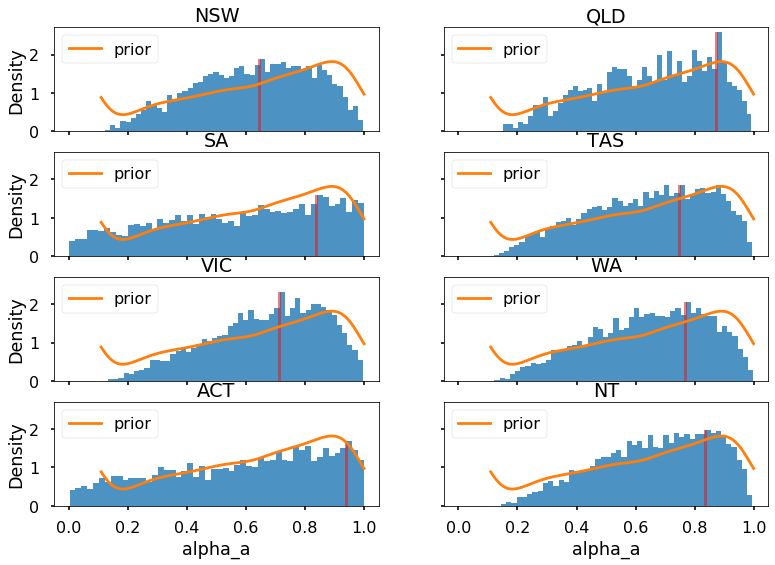

NSW alpha_s 1.0496110600944601
QLD alpha_s 1.109966926607167
SA alpha_s 1.0000968835278097
TAS alpha_s 1.0474364000771696
VIC alpha_s 1.046428876628793
WA alpha_s 1.054522978930571
ACT alpha_s 1.0002125735458343
NT alpha_s 1.0576759990044655


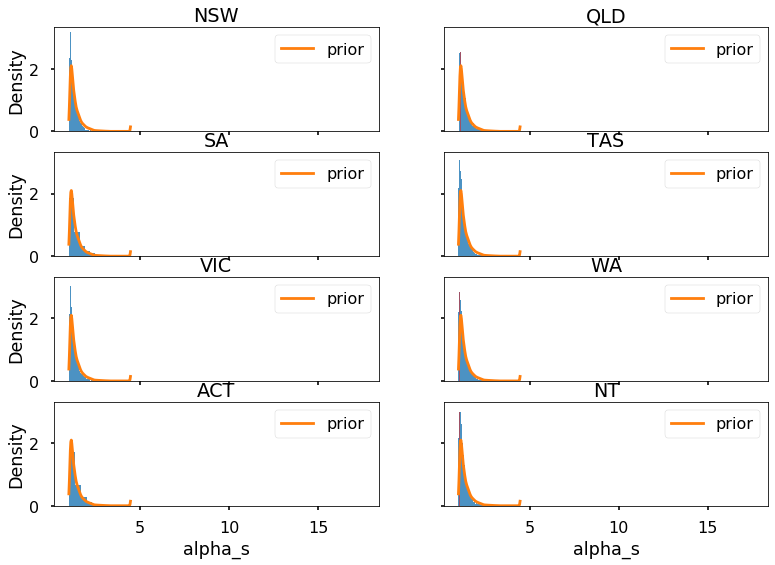

NSW gam 0.47689758233430046
QLD gam 0.7519285211868718
SA gam 0.20007186148478753
TAS gam 0.5839709331093326
VIC gam 0.4800355196267517
WA gam 0.463307934801197
ACT gam 0.10133772382370557
NT gam 0.6183132356175676


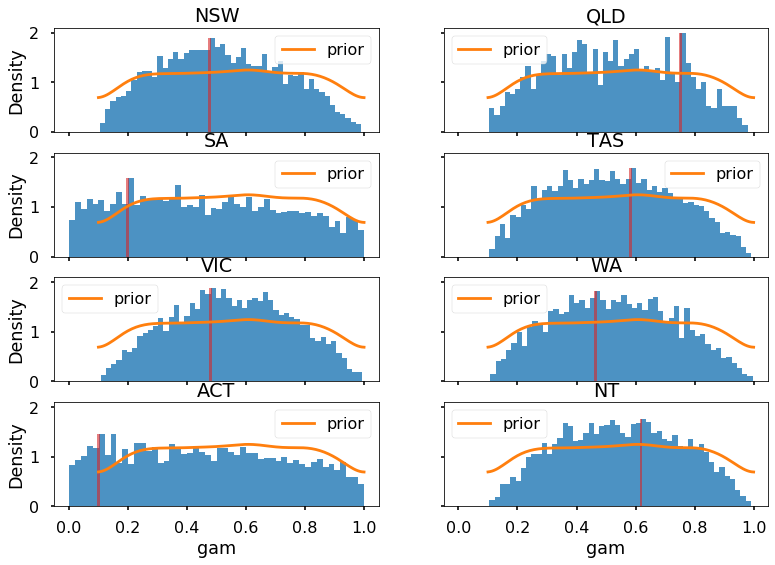

NSW ps 0.6476918323822161
QLD ps 0.5539113117145498
SA ps 0.6724880178991584
TAS ps 0.7109796402952561
VIC ps 0.6547139027238429
WA ps 0.5750348331086571
ACT ps 0.5111065782458136
NT ps 0.6049701640841485


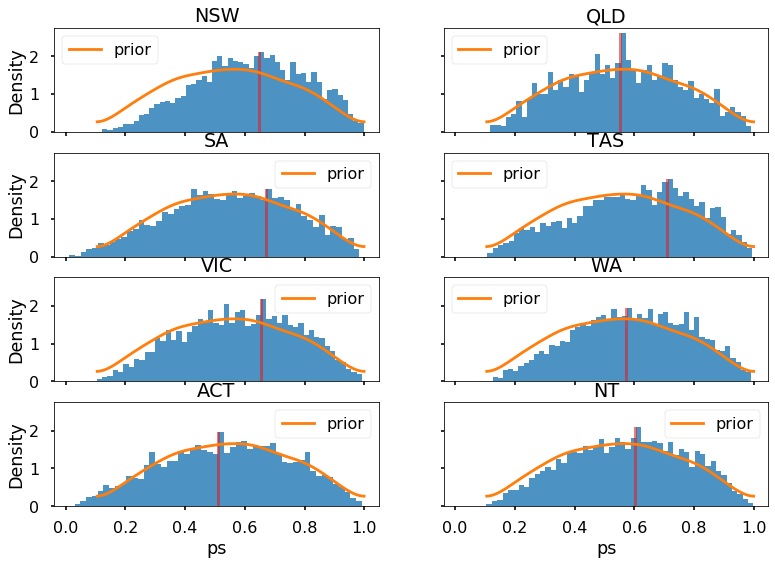

NSW qs 0.6921564667142707
QLD qs 0.5507445422779236
SA qs 0.5435900045009879
TAS qs 0.6189429410370985
VIC qs 0.36865312221630814
WA qs 0.5586868198122689
ACT qs 0.7555523527055771
NT qs 0.5834341927377078


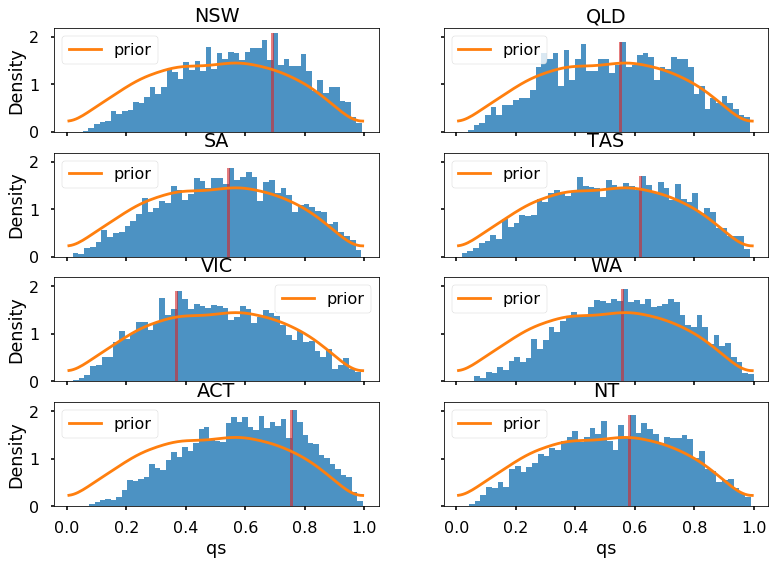

In [6]:
plot_bestsamples(dfs,'alpha_a',alpha_a_prior,fraction=0.1)
plot_bestsamples(dfs,'alpha_s',alpha_s_prior)
plot_bestsamples(dfs,'gam',gam)
plot_bestsamples(dfs,'ps',ps_prior,fraction=0.1)
plot_bestsamples(dfs,'qs',qs_prior,fraction=0.1)


In [7]:
#Get sample weights for each jurisdiction by total number of cumulative local cases

fraction =0.1
states_weight = df.groupby("STATE").cum_local.last()
states_weight = states_weight/sum(states_weight)
best = pd.DataFrame()
weights = []
for state in states:
    top = dfs[state].nsmallest(int(dfs[state].shape[0]*fraction), 'metrics')
    best = best.append(top)
    weights.extend([states_weight[state]] *top.shape[0])
    

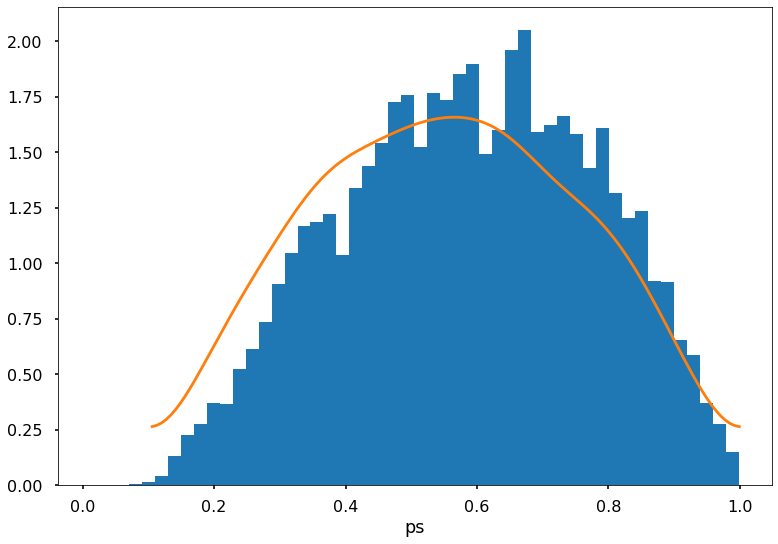

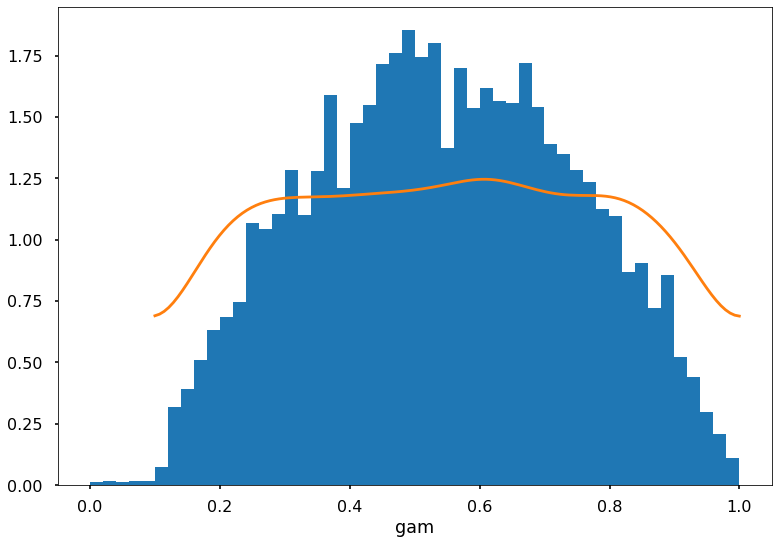

In [10]:
import seaborn as sns

var ='ps'
fig,ax = plt.subplots()

ax.hist(best[var], bins=50, weights=weights,density=True)
sns.kdeplot(ps_prior,cut=0,bw=0.05)
ax.set_xlabel(var)

var ='gam'
fig,ax = plt.subplots()

ax.hist(best.alpha_a/best.alpha_s, bins=50, weights=weights,density=True)
sns.kdeplot(gam,cut=0,bw=0.05)
ax.set_xlabel(var)
plt.show()


NSW qa 0.3072961534689043
QLD qa 0.27870327579891563
SA qa 0.20398351787178817
TAS qa 0.1695566820380758
VIC qa 0.15428521663887068
WA qa 0.24166428026958958
ACT qa 0.31107424868648775
NT qa 0.17291975542346535


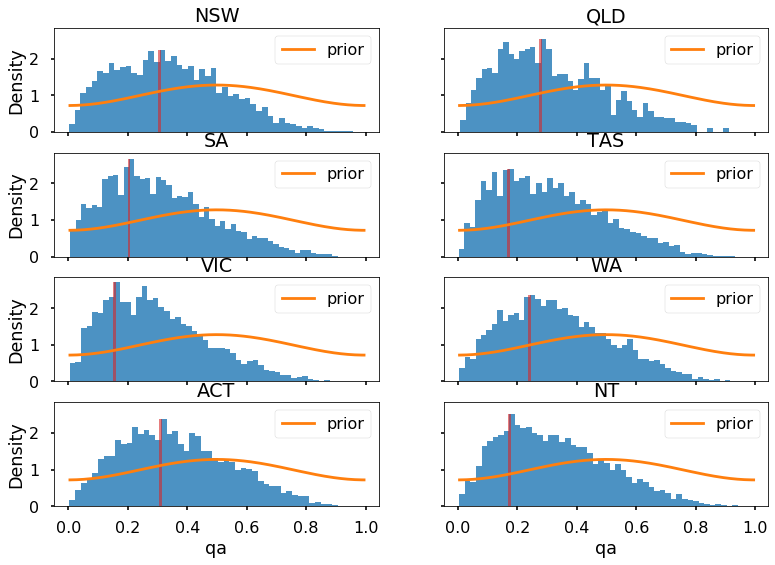

In [23]:
#note that in sim, qa is resampled until qa < qs
qa_prior = qs_prior
plot_bestsamples(dfs,'qa',qa_prior)

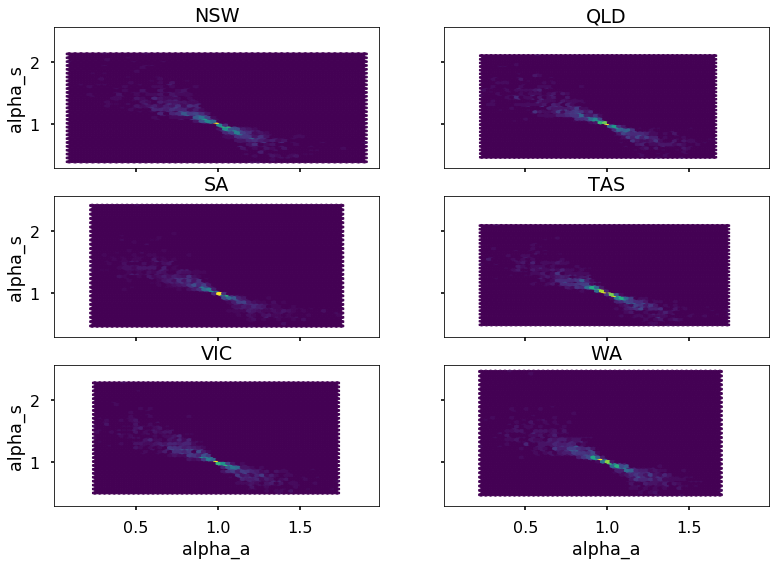

In [153]:
plot_hexbin(dfs,'alpha_a',yvalue = 'alpha_s',best=True)


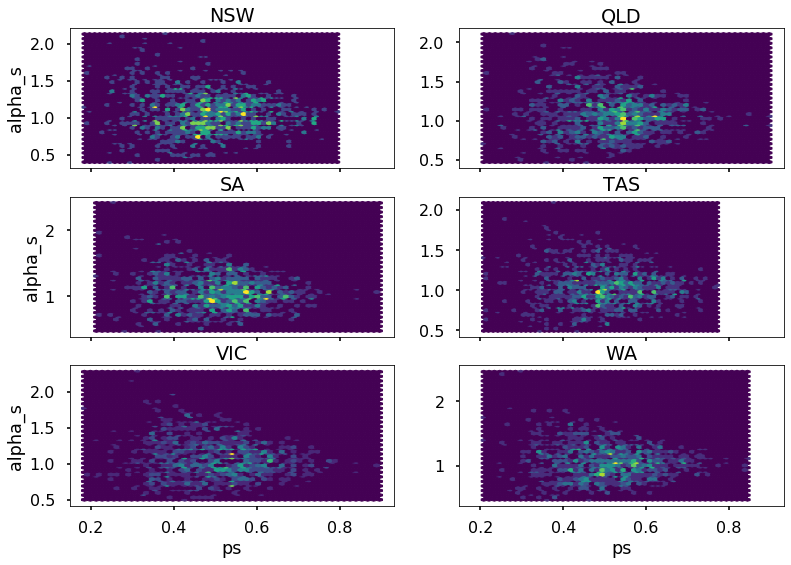

In [158]:
plot_hexbin(dfs,'ps',yvalue='alpha_s',best=True)

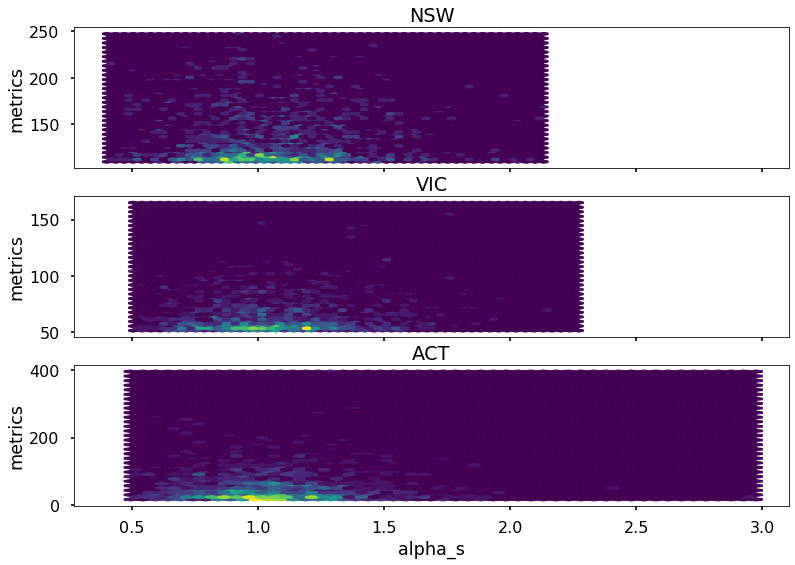

In [157]:
plot_hexbin(dfs,'alpha_s',states=['NSW','VIC','ACT'],best=True)

In [85]:
def get_metric(self,end_time,omega=0.2):
        """
        Calculate the value of the metric of the current sim compared 
        to NNDSS data
        """

        ##missing dates

        missed_dates = [day for day in range(end_time) 
            if day not in self.actual.keys()]

        self.actual_array = np.array([self.actual[day]
        if day not in missed_dates else 0 
        for day in range(end_time) ])

        #calculate case differences
        #moving windows
        sim_cases =self.observed_cases[
            :len(self.actual_array),2]
        
        #convolution with 1s should do cum sum 
        window = 7
        sim_cases = np.convolve(sim_cases,
            [1]*window,mode='valid')
        actual_cum = np.convolve(self.actual_array,
            [1]*window,mode='valid')
        cases_diff = abs(sim_cases - actual_cum)
        
        #if sum(cases_diff) <= omega * sum(self.actual_array):
            #cumulative diff passes, calculate metric

            #sum over days number of times within omega of actual
        self.metric = sum(np.less_equal(
            cases_diff,np.maximum(omega* actual_cum,7)
            ))
        
        self.metric = self.metric/(end_time-window) #max is end_time

        return None

sim
0     0.504505
1     0.135135
2     0.252252
3     0.288288
4     0.180180
5     0.081081
6     0.144144
7     0.261261
8     0.252252
9     0.225225
10    0.153153
11    0.333333
12    0.432432
13    0.351351
14    0.243243
15    0.216216
16    0.378378
17    0.207207
18    0.261261
19    0.162162
20    0.396396
21    0.171171
22    0.090090
23    0.090090
24    0.207207
25    0.585586
26    0.288288
27    0.153153
28    0.171171
29    0.225225
30    0.063063
31    0.333333
32    0.432432
33    0.216216
34    0.225225
35    0.396396
36    0.162162
37    0.279279
38    0.378378
39    0.252252
40    0.099099
41    0.405405
42    0.108108
43    0.288288
44    0.063063
45    0.171171
46    0.216216
47    0.216216
48    0.144144
49    0.027027
Name: metrics, dtype: float64

In [90]:
from datetime import datetime

df = df_cases_state_time.loc[df_cases_state_time.STATE=='NSW'][['date_inferred','local']]
df = df.loc[df.date_inferred>='2020-03-01']

In [93]:
df['date'] = df.date_inferred.apply(lambda x: x.dayofyear) -pd.to_datetime(
    start_date).dayofyear
df = df.sort_values(by='date')
actual = pd.Series(df.local.values, index =df.date.values).to_dict()
missed_dates = [day for day in range(days) 
            if day not in actual.keys()]
print(missed_dates)
actual_array = np.array([actual[day]
        if day not in missed_dates else 0 
        for day in range(days) ])

[62, 69, 70, 71, 75, 76, 81, 87, 88, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]


In [94]:
omega = 0.2
metrics=[]
for row in WA.index:
    


    sim_cases = WA.loc[row].values[
            :len(actual_array)]
    
        #convolution with 1s should do cum sum 
    window = 7
    sim_cases = np.convolve(sim_cases,
        [1]*window,mode='valid')
    
    actual_cum = np.convolve(actual_array,
        [1]*window,mode='valid')
    cases_diff = abs(sim_cases-actual_cum)
    
    metric = sum(np.less_equal(
            cases_diff,np.maximum(omega* actual_cum,7)
            ))
    
    metric = metric/days
    metrics.append(metric)


In [95]:
np.isclose(metrics, df_results.loc['symp_obs'].metrics.values)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [96]:
cases_diff

array([  6.,   9.,  14.,  20.,  18.,  36.,  39.,  45.,  35.,  44.,  58.,
        65.,  71.,  95.,  81., 101., 120., 132., 169., 179., 175., 188.,
       171., 173., 166., 147., 146., 126., 104.,  97.,  57.,  37.,   2.,
        43.,  67.,  74.,  78.,  85.,  83.,  70.,  68.,  58.,  62.,  59.,
        55.,  73.,  80.,  80.,  84.,  77.,  70.,  74.,  73.,  69.,  72.,
        69.,  60.,  64.,  56.,  53.,  55.,  39.,  35.,  31.,  24.,  21.,
        15.,  13.,  20.,  19.,  15.,  17.,  16.,  19.,  16.,  18.,  20.,
        19.,  21.,  23.,  26.,  26.,  27.,  25.,  27.,  25.,  26.,  24.,
        25.,  22.,  19.,  19.,  18.,  18.,  16.,  14.,  12.,  13.,  14.,
        16.,  14.,  14.,  16.,  19.,  18.,  16.,  11.,  12.,  12.,  11.,
         9.,   9.])

In [97]:
actual_cum

array([ 26,  29,  33,  38,  36,  48,  59,  72,  75,  97, 123, 140, 162,
       191, 193, 227, 260, 284, 331, 345, 361, 370, 363, 370, 376, 366,
       371, 351, 340, 324, 278, 244, 204, 163, 131, 117, 101,  96,  95,
        87,  76,  86,  85,  89,  78,  53,  53,  54,  38,  39,  37,  34,
        35,  29,  25,  26,  21,  20,  25,  23,  22,  24,  22,  22,  19,
        13,  13,  12,   8,   7,   7,   7,   7,   5,   4,   2,   2,   3,
         3,   5,   4,   3,   3,   3,   2,   2,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [98]:
sum(np.less_equal(
            cases_diff,np.maximum(omega* actual_cum,7)
            ))/days

0.025423728813559324

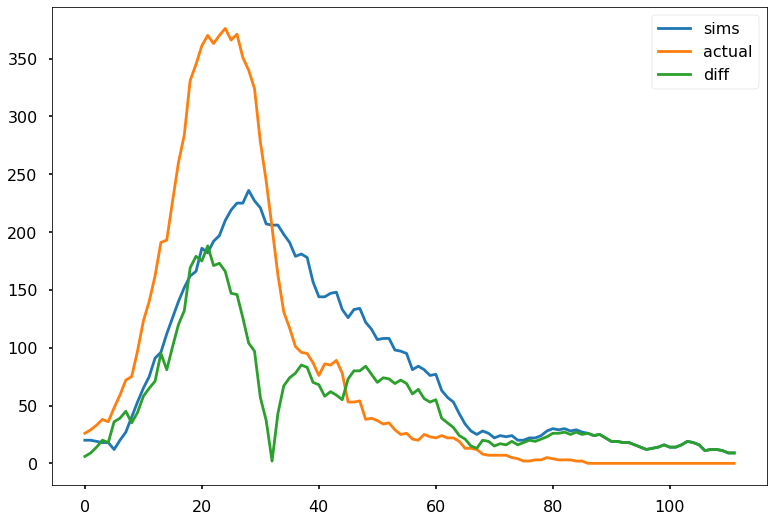

In [147]:
fig,ax = plt.subplots()
ax.plot(range(days-window+1),sim_cases, label='sims')
ax.plot(range(days-window+1),actual_cum,label='actual')
ax.plot(range(days-window+1),cases_diff, label='diff')
plt.legend()
plt.show()

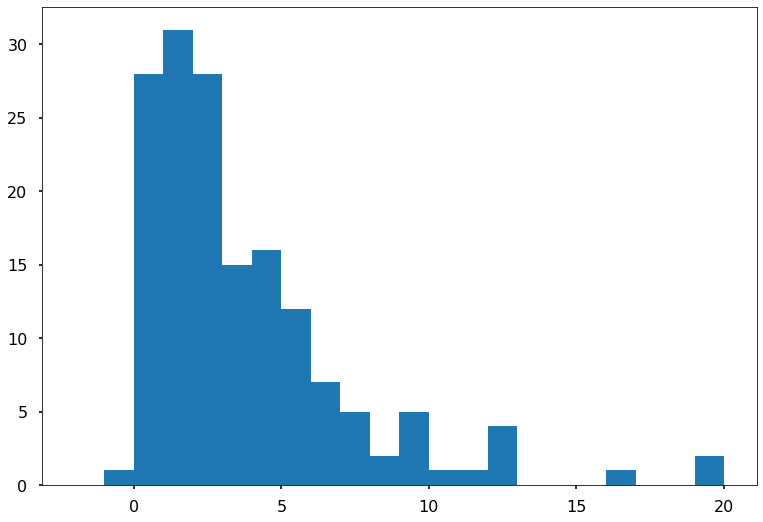

In [185]:
df['onset_notifi_diff'] = df.date_inferred -df.TRUE_ONSET_DATE

s = df.loc[(df.date_inferred<='2020-03-15')&(df.local==1)].onset_notifi_diff
plt.hist(s.astype('timedelta64[D]'),bins=22,range=(-2,20))

plt.show()

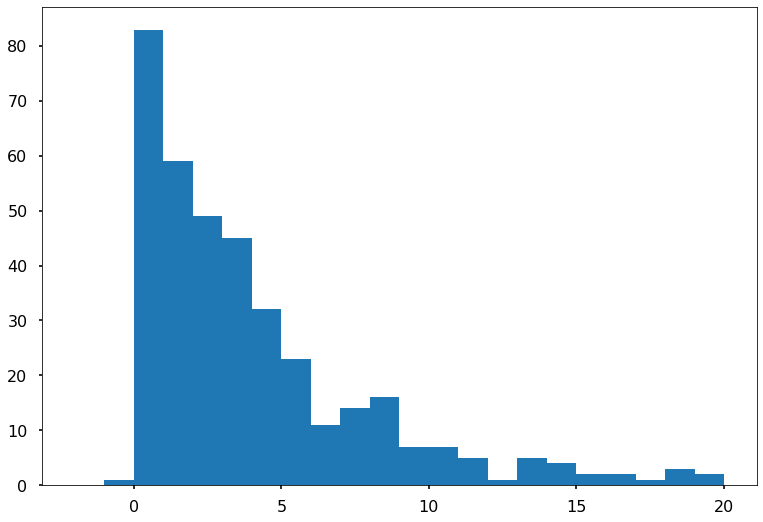

In [186]:
df['onset_notifi_diff'] = df.date_inferred -df.TRUE_ONSET_DATE

s = df.loc[(df.date_inferred<='2020-03-15')&(df.local==0)].onset_notifi_diff
plt.hist(s.astype('timedelta64[D]'),bins=22,range=(-2,20))

plt.show()

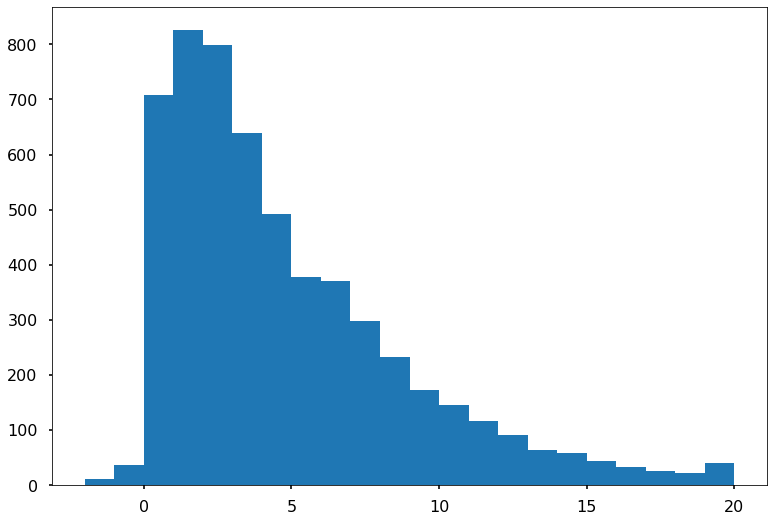

In [183]:
df['onset_notifi_diff'] = df.date_inferred -df.TRUE_ONSET_DATE

s = df.loc[(df.date_inferred>='2020-03-15')&(df.date_inferred<='2020-04-15')].onset_notifi_diff
plt.hist(s.astype('timedelta64[D]'),bins=22,range=(-2,20))

plt.show()

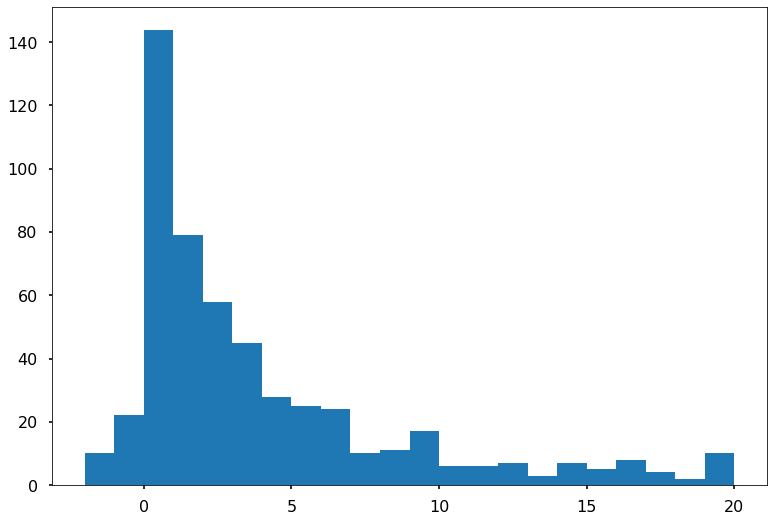

In [184]:
df['onset_notifi_diff'] = df.date_inferred -df.TRUE_ONSET_DATE

s = df.loc[(df.date_inferred>='2020-04-15')].onset_notifi_diff
plt.hist(s.astype('timedelta64[D]'),bins=22,range=(-2,20))

plt.show()